In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dropout, Dense

In [2]:
train_dir = '../../dataset_26'
test_dir = '../../dataset_26'

classes = os.listdir(train_dir) 
# classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

# os.mkdir('content/Train-Data')
# os.mkdir('content/Test-Data')

# for cls in classes:
  # os.mkdir(f'content/Train-Data/{cls}')
  # os.mkdir(f'content/Test-Data/{cls}')

In [3]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [4]:
train_files_path = {cls: list(map(lambda x: os.path.join(train_dir, cls, x), os.listdir(os.path.join(train_dir, cls)))) for cls in classes}

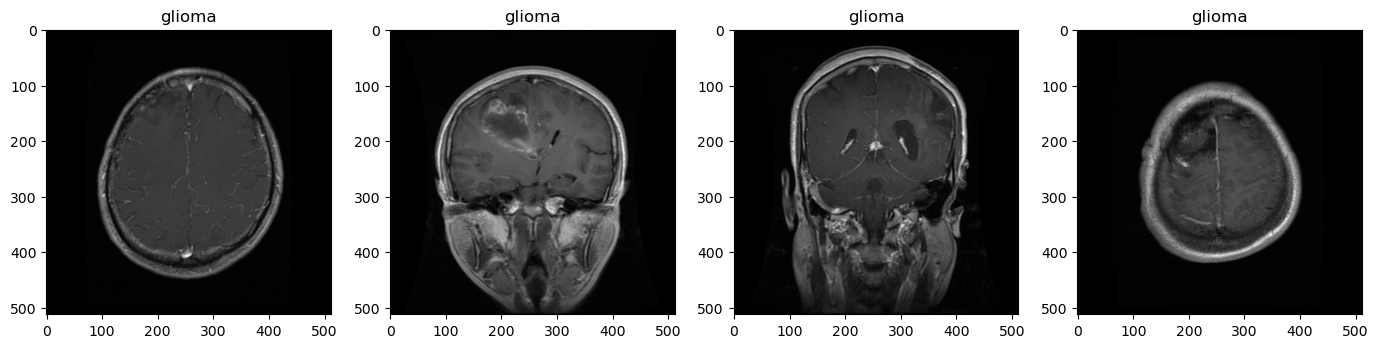

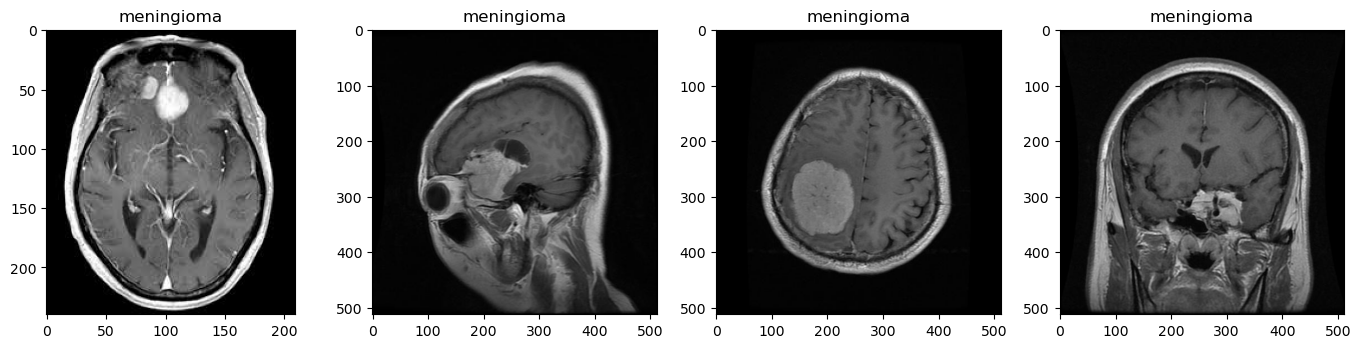

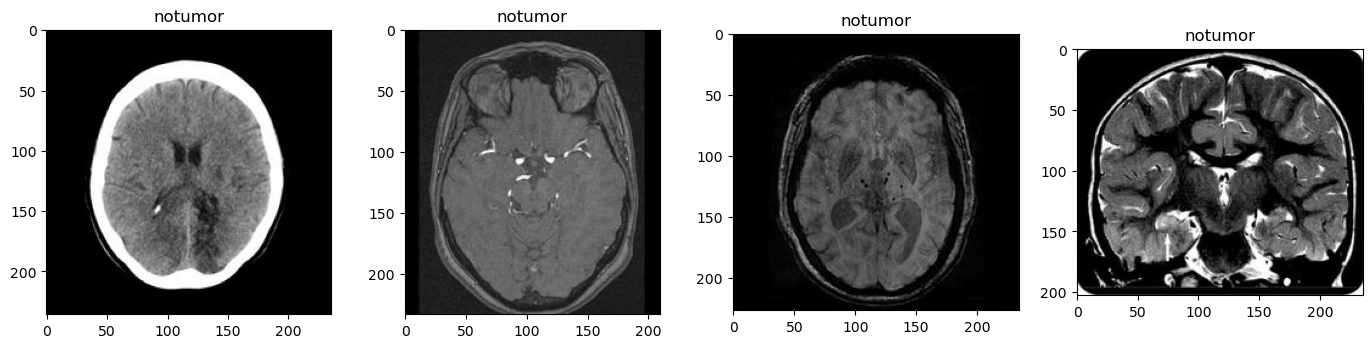

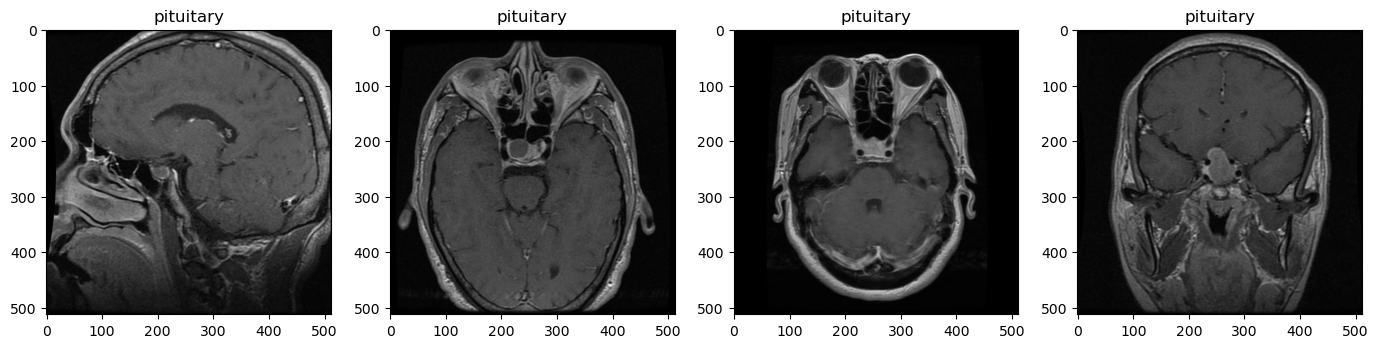

In [5]:
for cls in classes:
  plt.figure(figsize=(17, 17))
  random.shuffle(train_files_path[cls])
  files = train_files_path[cls][:5]

  for i in range(1, 5):
    plt.subplot(4, 4, i)
    plt.imshow(load_img(files[i]))
    plt.title(cls)

In [6]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [7]:
# glioma = os.path.join(train_dir, 'glioma_tumor')
# meningioma = os.path.join(train_dir, 'meningioma_tumor')
# pituitary = os.path.join(train_dir, 'pituitary_tumor')
# no_tumor = os.path.join(train_dir, 'no_tumor')

### All above paths to train class directories in the following list
train_class_paths = [os.path.join(train_dir, cls) for cls in classes]
print(train_class_paths)

test_class_paths = [os.path.join(test_dir, cls) for cls in classes]

['../../dataset_26\\glioma', '../../dataset_26\\meningioma', '../../dataset_26\\notumor', '../../dataset_26\\pituitary']


In [8]:
def crop_img_saver(class_read_paths, save_dir):
  save_root = 'content'
  for cls in class_read_paths:
    for i, p in tqdm(enumerate(os.listdir(cls))):
      path = os.path.join(cls, p)
      img = crop_image(cv2.imread(path), plot=False)

      if img is not None:
        img = cv2.resize(img, (224, 224))
        save_class = cls.split('\\')[-1]
        save_path = os.path.join(save_root, save_dir, save_class, f'{str(i)}.jpg')
        cv2.imwrite(save_path, img)

In [9]:
crop_img_saver(train_class_paths, save_dir='Train-Data')

crop_img_saver(test_class_paths, save_dir='Test-Data')

120it [00:00, 165.31it/s]
120it [00:00, 167.63it/s]
120it [00:00, 142.69it/s]
120it [00:00, 150.29it/s]
120it [00:00, 197.48it/s]
120it [00:00, 163.05it/s]
120it [00:05, 20.41it/s]
120it [00:00, 145.74it/s]


In [10]:
train_data_generator = ImageDataGenerator(rotation_range=10, 
                                          height_shift_range=0.2, 
                                          horizontal_flip=True, 
                                          validation_split=0.2)

train_data = train_data_generator.flow_from_directory('content/Train-Data',
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      subset='training')

validation_data = train_data_generator.flow_from_directory('content/Train-Data',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='categorical',
                                                           subset='validation')

test_data_generator = ImageDataGenerator()

test_data = test_data_generator.flow_from_directory('content/Test-Data/',
                                        target_size=(224, 224),
                                        class_mode='categorical')

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Found 480 images belonging to 4 classes.


In [11]:
print(train_data.class_indices, test_data.class_indices, sep='\n')

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


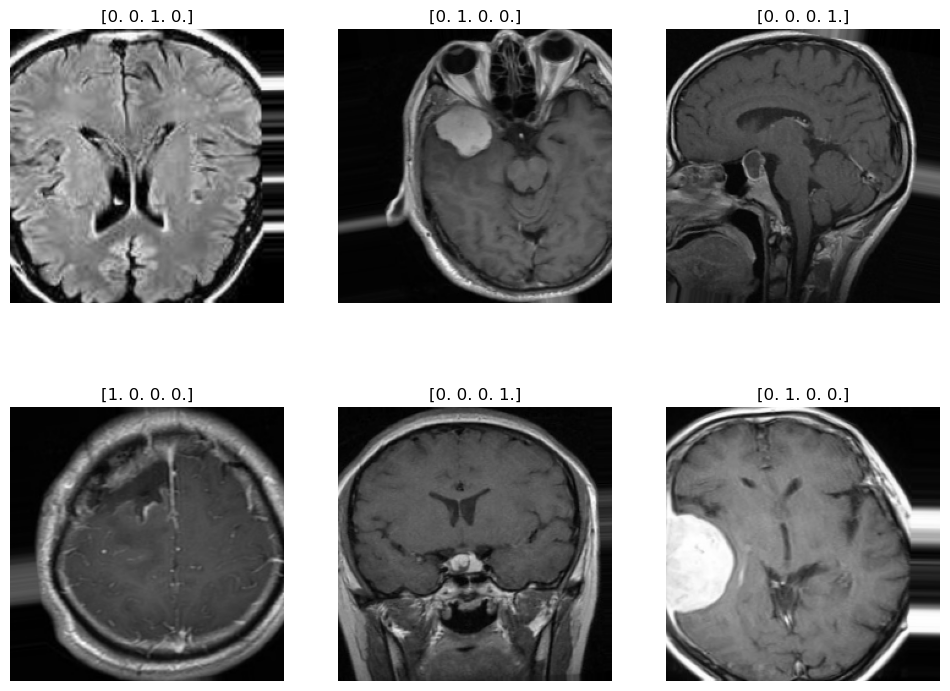

In [12]:
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.axis('off'), plt.grid(False)
  # sample_img = array_to_img(sample_x[i])
  plt.imshow(array_to_img(sample_x[i]))
  plt.title(sample_y[i])

In [13]:
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs=model)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5,
                                                  mode='auto',
                                                  verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model_ckpt.model.keras', 
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                mode='auto',
                                                verbose=1)

In [17]:
history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=validation_data, 
                    callbacks=[checkpoint, early_stopping], 
                    verbose=1)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3371 - loss: 1.4033
Epoch 1: val_accuracy improved from -inf to 0.36458, saving model to model_ckpt.model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 176s 9s/step - accuracy: 0.3402 - loss: 1.3993 - val_accuracy: 0.3646 - val_loss: 1.2784
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6383 - loss: 0.9926
Epoch 2: val_accuracy improved from 0.36458 to 0.51042, saving model to model_ckpt.model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 107s 9s/step - accuracy: 0.6397 - loss: 0.9887 - val_accuracy: 0.5104 - val_loss: 1.1235
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7408 - loss: 0.7712
Epoch 3: val_accuracy improved from 0.51042 to 0.61458, saving model to model_ckpt.model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 107s 9s/step - accuracy: 0.7447 - loss: 0.7652 - val_accuracy: 0.6146 - val_loss: 1.0551
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8349 - loss: 0.6204
Epoch 4: val_accuracy did not improve 

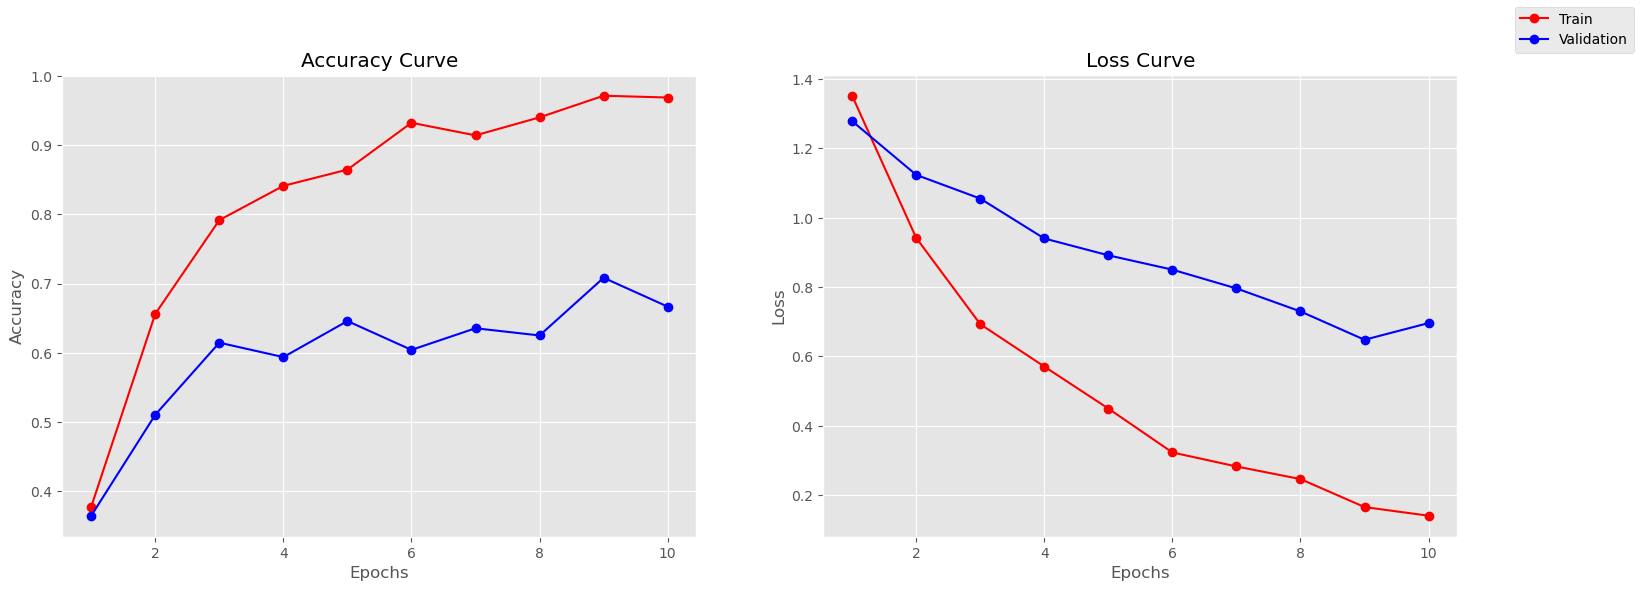

In [18]:
plt.style.use('ggplot')
figure = plt.figure(figsize=(18, 6))
epochs = range(1, 11)

plt.subplot(121)
plt.plot(epochs, history.history['accuracy'], 'ro-')
plt.plot(epochs, history.history['val_accuracy'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy Curve')

plt.subplot(122)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss Curve')

figure.legend(['Train', 'Validation'])

In [19]:
model.evaluate(test_data)

C:\Users\Mirza Anaqi\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8150 - loss: 0.4707


[0.4650026261806488, 0.8041666746139526]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Model prediction probabilities: [[0.00974981 0.8924377  0.08631721 0.01149528]]
Output Class Label: 1
Predicted Class: meningioma


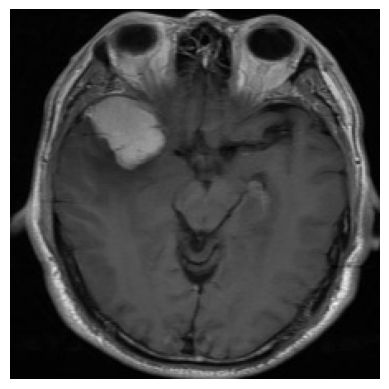

In [24]:
label_map = {v: k for k, v in test_data.class_indices.items()}

test_image = cv2.imread('content/Test-Data/meningioma/100.jpg')
plt.grid(0), plt.axis('off')
plt.imshow(test_image)
test_image = np.expand_dims(test_image, axis=0)

pred = model.predict(test_image)
print(f'Model prediction probabilities: {pred}')
pred = np.argmax(pred)
print(f'Output Class Label: {pred}')
pred = label_map[pred]
print(f'Predicted Class: {pred}')